<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset paths
train_dir = "/content/drive/My Drive/train/"
test_dir = "/content/drive/My Drive/test1/"

# Function to load and preprocess images
def load_images(directory, size=(56, 56)):
    images = []
    filenames = os.listdir(directory)
    for file in filenames:
        img = load_img(os.path.join(directory, file), target_size=size)
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Load and preprocess images
x_train = load_images(train_dir)
x_test = load_images(test_dir)

# Reshape for model compatibility
x_train = np.reshape(x_train, (len(x_train), 56, 56, 3))
x_test = np.reshape(x_test, (len(x_test), 56, 56, 3))

# Add noise to training data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the autoencoder model
input_img = Input(shape=(56, 56, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train model
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Save model
autoencoder.save("/content/drive/My Drive/image_upscaler.keras", save_format='keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 69s 166ms/step - loss: 0.0435 - val_loss: 0.0284
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - loss: 0.0282 - val_loss: 0.0266
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - loss: 0.0261 - val_loss: 0.0254
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - loss: 0.0251 - val_loss: 0.0251
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 0.0243 - val_loss: 0.0239
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 163ms/step - loss: 0.0237 - val_loss: 0.0234
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - loss: 0.0235 - val_loss: 0.0232
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 154ms/step - loss: 0.0233

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step


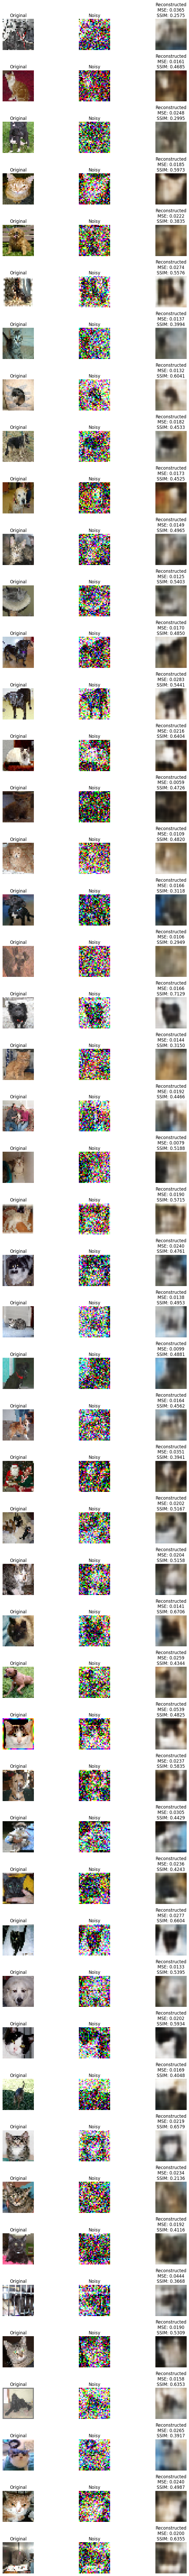

Average MSE: 0.0205
Average SSIM: 0.4845


In [11]:
# Load trained model and visualize output
num_images = 50  # Reduced for demonstration purposes
test_samples = x_test_noisy[:num_images]
reconstructed = autoencoder.predict(test_samples)

# Initialize lists to store MSE and SSIM values
mse_values = []
ssim_values = []

fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
for i in range(num_images):
    # Original image
    original = x_test[i]
    # Noisy input
    noisy = test_samples[i]
    # Reconstructed image
    recon = reconstructed[i]

    # Calculate MSE
    mse = mean_squared_error(original.flatten(), recon.flatten())
    mse_values.append(mse)

    # Calculate SSIM
    ssim_index = ssim(original, recon, data_range=1.0, channel_axis=-1)
    ssim_values.append(ssim_index)

    # Display images
    axes[i, 0].imshow(original)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(noisy)
    axes[i, 1].set_title("Noisy")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(recon)
    axes[i, 2].set_title(f"Reconstructed\nMSE: {mse:.4f}\nSSIM: {ssim_index:.4f}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Print average MSE and SSIM
print(f"Average MSE: {np.mean(mse_values):.4f}")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

In [2]:
!pip install skimage

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
